In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import gym
import numpy as np
import random
import tensorflow as tf
env = gym.make('FrozenLake-v0')
tf.reset_default_graph()

[2017-10-14 20:47:15,571] Making new env: FrozenLake-v0


In [2]:
#These lines establish the feed-forward part of the network used to choose actions
inputs1 = tf.placeholder(shape=[1,16],dtype=tf.float32)
W = tf.Variable(tf.random_uniform([16,4],0,0.01))
Qout = tf.matmul(inputs1,W)
predict = tf.argmax(Qout,1)

#Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1,4],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

In [3]:
init = tf.global_variables_initializer()

# Set learning parameters
y = .99
e = 0.1
num_episodes = 2000
#create lists to contain total rewards and steps per episode
jList = []
rList = []
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        #Reset environment and get first new observation
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        #The Q-Network
        while j < 99:
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(16)[s:s+1]})
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()
            #Get new state and reward from environment
            s1,r,d,_ = env.step(a[0])
            #Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout,feed_dict={inputs1:np.identity(16)[s1:s1+1]})
            #Obtain maxQ' and set our target value for chosen action.
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0,a[0]] = r + y*maxQ1
            #Train our network using target and predicted Q values
            _,W1 = sess.run([updateModel,W],feed_dict={inputs1:np.identity(16)[s:s+1],nextQ:targetQ})
            rAll += r
            s = s1
            if d == True:
                #Reduce chance of random action as we train the model.
                e = 1./((i/50) + 10)
                break
        jList.append(j)
        rList.append(rAll)
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Percent of succesful episodes: 0.402%


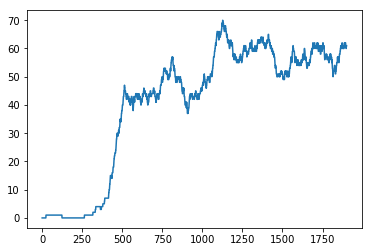

In [4]:
plt.plot(np.convolve(np.ones(100),rList,"valid"))